# Colab setup
Clone the [OpenCows2020Dataset](https://github.com/Asheeshkrsharma/OpenCows2020Dataset.git) repository by [Asheeshkrsharma](https://github.com/Asheeshkrsharma) (me). This is necessary because local dependencies and directories are not retained by Google Colab when this notebook is opened. *Not necessary* in case if the notebook is run on a local machine.

In [1]:
# Google Colab, clone the repository for helper functions
%rm -rf * && rm -rf .*
!git clone https://github.com/Asheeshkrsharma/Identification-OpenCows.git .

rm: refusing to remove '.' or '..' directory: skipping '.'
rm: refusing to remove '.' or '..' directory: skipping '..'
Cloning into '.'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 63 (delta 3), reused 15 (delta 2), pack-reused 45
Unpacking objects: 100% (63/63), done.
Checking out files: 100% (20/20), done.


# Introduction
Identifying individuals in a group of animals is an active research topic as it paves the way to behavioural studies, including lameness and illness detection. In this notebook, we replicated an identification technique that proposes metric learning for open-set identification of Holstein-Friesian cattle (i.e. identifying unknown cattle, not trained against, not requiring any training) [<sup>[1]</sup>](#fn1). To train a convolutional neural network, we used a opensource dataset called [OpenCows2020](https://data.bris.ac.uk/data/dataset/10m32xl88x2b61zlkkgz3fml17) [<sup>[2]</sup>](#fn2) released under [Non-Commercial Government Licence for public sector information](http://www.nationalarchives.gov.uk/doc/non-commercial-government-licence/non-commercial-government-licence.htm).

We then test the trained model's embedding to evaluate if they are qualitatively unique using K-nearest neighbours, and each value in the embedding is an independent variable (no correlation). Finally, using TSNE dimensionality reduction, we visualize the embeddings for individuals.

> 📓 **This is a faithful (from scratch) re-implementation of the original paper focusing on using the PyTorch built-in functions. The original repository associated with the Andrew et al. paper[<sup>[1]</sup>](#fn1) uses a custom ResNet `nn.module`, whereas here, we directly rely on what PyTorch can offer. It is worth noting that, the results presented here, challenge the results from the Andrew et al. paper[<sup>[1]</sup>](#fn1) (we achieve a higher accuracy), the cause of which can be attributed to minor oversights to the PyTorch documentation by the original authors and the different model training routine used here.**

In [2]:
# Uncomment to following to install the depedencies
!pip3 install hiddenlayer
!pip3 install graphviz
!pip3 install tqdm
!pip3 install umap-learn

import os # For directory listing

# Maing dependency is pytorch
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
import torchvision.models as models
from torchvision import transforms

# For visualization
import matplotlib.pyplot as plt
import hiddenlayer as hl

# Usual math
import numpy

# Progress
from tqdm import tqdm

# Model evaluation
from sklearn.neighbors import KNeighborsClassifier

     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 53.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=987f9e567c103006b0f566b9e96806f1438f1fa33eef0a6888a6e56e380135a5
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=537d928deb905ddf3e31f9f7ee656f09281dbfb2425aa1adc464e0d8a37832ce
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


# Methods

## Opencows dataset exploration
### Configuring the dataset
* Instead of downloading the entire dataset (~2 GB), the following cell downloads just the identification part using `xargs` and `wget`. The [data.bris.ac.uk](https://data.bris.ac.uk/data/dataset/10m32xl88x2b61zlkkgz3fml17) `CKAN` server is relatively slow; it takes more than 2 hours to download the entire dataset. This reduces the download time to about three minutes.

> ⚠️ **wget is required to download the dataset (on mac run `brew install wget`). There is a chance of the following not working on windows as some unix commands are required. In the situation where the following cell does not work, please follow these steps**
* Download the dataset from [here](https://data.bris.ac.uk/data/dataset/10m32xl88x2b61zlkkgz3fml17).
* Place the contents (two folders: images/ and splits/) of the identification folder in datasets/OpenSetCows2020/ relative to the repository's root.

In [3]:
with tqdm(range(2), desc="Preparing dataset") as pbar:
  # Lambda function updates the tqdm progress bar.
  tqdmDescribe = lambda message, pbar: pbar.set_description(message); pbar.refresh()
  # The list of files is stored in the following files
  files = list(open("./utils/datasetLinks.txt", "r").readlines())
  tqdmDescribe(f"Downloading OpenSetCows2020 ({len(files)} files from data.bris.ac.uk)", pbar)
  # This downloads a 500 files concurrently using wget. (takes roughly 2 minutes)
  %rm -rf datasets && cat ./utils/datasetLinks.txt | xargs -n 500 -P 8 wget -x -nH -q
  pbar.update()
  tqdmDescribe(f"Organizing dataset", pbar)
  %mkdir -p datasets/OpenSetCows2020
  %mv -f ./datasets/*/identification/* ./datasets/OpenSetCows2020/ 2>/dev/null
  %rm -rf ./datasets/10m32xl88x2b61zlkkgz3fml17
  pbar.update()

Organizing dataset: 100%|██████████| 2/2 [01:51<00:00, 55.83s/it]


### Reading the dataset
The `OpenSetCows2020` pytorch class was modified because the orignal repository that comes with the paper[<sup>[1]</sup>](#fn1) *does not* normalize images around the mean as required by the pytorch model zoo weights (see [line 183](https://github.com/CWOA/MetricLearningIdentification/blob/1ae50c819da735901fd21a7f19293092bb0b2422/datasets/OpenSetCows2020/OpenSetCows2020.py#L183) in `OpenCows2020.py`). The following is quoted directly from the pytorch [documentation](https://pytorch.org/vision/stable/models.html):

> All pre-trained models expect input images normalised in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. You can use the following transform to normalise:
 ```python
 normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225])
 ```

While normalising the image data, the range numerical range shifts from (0, 1) to (-1, 1). The matplotlib's `imshow` function checks for invalid data and replaces the negative values with zeros. The images are temporarily "untransformed" for viewing purposes and to avoid colour clipping. Following custom transform from [this](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3) PyTorch discussion forum was used to revert mean normalization (See [this](https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3) comment by [Joel Simon](https://discuss.pytorch.org/u/joels/summary)):
```python
class UnNormalize(object):
 def __init__(self, mean, std):
 self.mean = mean
 self.std = std

 def __call__(self, tensor):
 """
 Args:
 tensor (Tensor): Tensor image of size (C, H, W) to be normalised.
 Returns:
 Tensor: Normalised image.
 """
 for t, m, s in zip(tensor, self.mean, self.std):
 t.mul_(s).add_(m)
 # The normalize code -> t.sub_(m).div_(s)
 return tensor
```

This dataset (train split, 1 fold) has 35 known and 11 unknown categories, with combinations turned on.
It has 4240 images in the train set and 496 in the test set.
You can try to plot the triplet samples by `dataset.plotSamples(<number of samples>)`, and see the distribution by `dataset.distribution()`


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


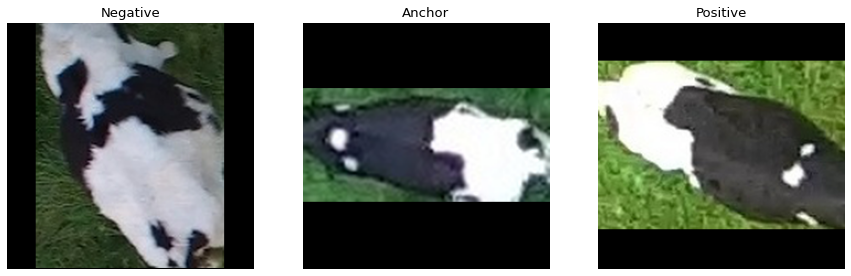

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


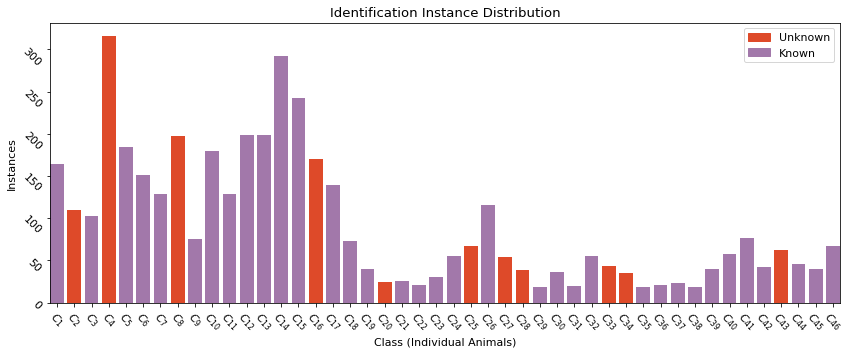

In [4]:
# I have modified the underlying nn.dataset class to make the figures and image
# normalisation.

from utils.OpenSetCows2020 import OpenSetCows2020

# The file contains a list of image files to use for training and testing
foldsFile = "datasets/OpenSetCows2020/splits/75-25.json"

trainDataset = OpenSetCows2020(
    0,  # Fold 0
    foldsFile,
    split="train",
    transform=True,  # --------⎤
    combine=True,  # -----------> Arguments taken as specified in the Paper.
    suppress_info=False,  # ---⎦
)

# Plot
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "Arial"
plt.rcParams.update({'font.size': 11})
plt.rcParams["figure.figsize"] = (15, 5)
trainDataset.plotSamples(1)
plt.rcParams["figure.figsize"] = (11.84, 5)
trainDataset.distribution()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.show()

## ResNet based model for deep metric learning
### Construction
Andrew Et al. [<sup>[1]</sup>](#fn1) proposed a ResNet model as a backbone for features which can then be reduced to a one-dimensional embedding. The idea is to represent individual cows using the embedding in a latent space that can be classified with algorithms such as K-nearest neighbours. In theory, unknown individual embeddings (ones not seen during the training) should be significantly distant if the model had learnt discriminative features, eliminating the need for re-training to account for new individuals.

The study used the Resnet50 [<sup>[3]</sup>](#fn3) model with pre-trained weight from Imagenet, which can be found [here](https://pytorch.org/vision/stable/models.html). We used `resnet50-19c8e357.pth `

![](https://github.com/Asheeshkrsharma/Identification-OpenCows/blob/main/staticAssets/Model.svg?raw=1)

In [5]:
class ResNetMod(nn.Module):
    def __init__(self, numClasses, embeddingSize=128):
        """Initialize the model

        Parameters
        ----------
        numClasses : Int
            Number of classes (or individuals in a dataset)
        embeddingSize : Int, optional
            Size of the final embedding used differentiate individuals

        Returns
        -------
        A ResNetMod class instance
        """
        super(ResNetMod, self).__init__()

        # We create a resnet50 block and load imagenet weight into it
        self.backbone = models.resnet50(pretrained=True)
        imagenetWeights = model_zoo.load_url(
            "https://download.pytorch.org/models/resnet50-19c8e357.pth"
        )
        self.backbone.load_state_dict(imagenetWeights)

        # This layers is trained again, bias is set to true.
        self.backbone.fc = nn.Linear(2048, 1000)
        self.relu = nn.ReLU(inplace=True)
        self.embedding = nn.Linear(1000, embeddingSize)
        self.softmax = nn.Linear(1000, numClasses)

    def forwardOnce(self, x):
        """Forward through the network once

        Parameters
        ----------
        x : Input image to embed
            [Batch Size, Channel, Width, Height]

        Returns
        -------
        Embedding
            [Batch Size, 128]
        Softmax
            [Batch Size, Num Classes]
        """

        # Conv1 -> Relu(bn1) -> maxpool
        x = self.backbone.maxpool(
            self.backbone.relu(self.backbone.bn1(self.backbone.conv1(x)))
        )
        # avgpool(Layer 1 -> Layer 2 -> Layer 3 -> Layer 4)
        x = self.backbone.avgpool(
            self.backbone.layer4(
                self.backbone.layer3(self.backbone.layer2(self.backbone.layer1(x)))
            )
        )
        # Relu(FC)
        x = self.relu(self.backbone.fc(x.view(x.size(0), -1)))
        return self.embedding(x), self.softmax(x)

    def forward(self, anchor, negative=None, positive=None):
        """Forward the network

        Parameters
        ----------
        anchor : Input image to embed
            [Batch Size, Channel, Width, Height]
        negative : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss
        positive : Input image, optional
            [Batch Size, Channel, Width, Height] used during
            training with Triplet loss

        Returns
        -------
        list
            Embeddings and softmax ouputs for negative, anchor,
            and postive triplets in case nagative and postive
            image inputs are provided. Otherwise, returns a
            single embedding and softmax output.
        """
        if (negative != None) & (positive != None):
            negativeEMBD, negativeSMax = self.forwardOnce(negative)
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            positiveEMBD, positiveSMax = self.forwardOnce(positive)
            return (
                negativeEMBD, anchorEMBD, positiveEMBD,
                torch.cat((negativeSMax, anchorSMax, positiveSMax), 0),
            )
        else:
            anchorEMBD, anchorSMax = self.forwardOnce(anchor)
            return anchorEMBD, anchorSMax

    def __repr__(self):
        summary = f"{self.backbone.conv1.__repr__()} \n{self.backbone.bn1.__repr__()}"
        summary += "\nResnet Backbone: \n"
        layers = [
            self.backbone.layer1, self.backbone.layer2,
            self.backbone.layer3, self.backbone.layer4,
        ]
        for layer in layers:
            parameters = list(layer.named_parameters())
            summary += (
                f"\t ⎣ Input: {list(parameters[0][1].size())}"
                + f" -> Output: {list(parameters[-1][1].size())} ↩\n"
            )
        summary += self.backbone.fc.__repr__()
        summary += "\nOutput 1: " + self.embedding.__repr__()
        summary += "\nOutput 2: " + self.softmax.__repr__()
        return summary


### Model summary and Visualization

> 📓 **Note**: Following cell might result in an error while building the graph. Re-running the cell, should resolve the issue.

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resnet Backbone: 
	 ⎣ Input: [64, 64, 1, 1] -> Output: [256] ↩
	 ⎣ Input: [128, 256, 1, 1] -> Output: [512] ↩
	 ⎣ Input: [256, 512, 1, 1] -> Output: [1024] ↩
	 ⎣ Input: [512, 1024, 1, 1] -> Output: [2048] ↩
Linear(in_features=2048, out_features=1000, bias=True)
Output 1: Linear(in_features=1000, out_features=128, bias=True)
Output 2: Linear(in_features=1000, out_features=46, bias=True)


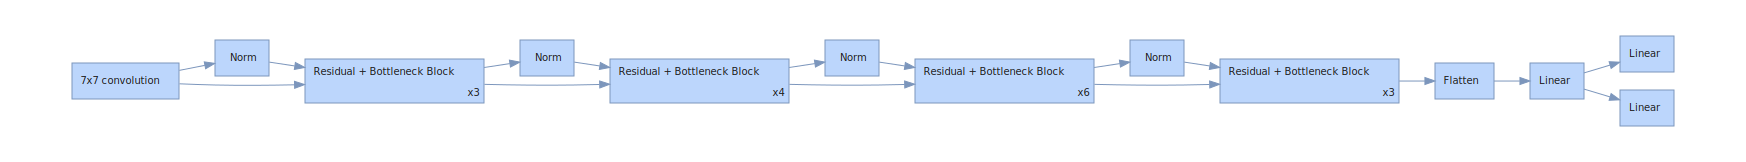

In [7]:
# Create the model and load weights (imagenet)
model = ResNetMod(trainDataset.getNumClasses())
print(model)

# Use tranforms from hidden layer library, to hide some blocks
# otherwise the graph will be too long.
transforms = [
    # Consolidate input convolution
    hl.transforms.Fold("Conv > BatchNorm > Relu > MaxPool", "convFirst", "7x7 convolution"),
    
    # Fold Bottle neeck and residual blocks
    hl.transforms.Fold("Conv > BatchNorm > Relu > Conv > BatchNorm > Relu > Conv > BatchNorm > Add > Relu", "ConvBnRelu", "Residual + Bottleneck\n Block"),
    hl.transforms.Fold("Conv > BatchNorm", "Out", "Norm"),
    hl.transforms.FoldDuplicates(),

    # Transforms for flattening
    hl.transforms.Fold("Shape > Gather > Unsqueeze > Concat > Reshape", "output", "Flatten"),
    hl.transforms.Fold("(Constant > Unsqueeze) > output", "output", "Flatten"),
    hl.transforms.Fold("Constant > output", "output", "Flatten"),
    hl.transforms.Fold("GlobalAveragePool > output", "output", "Flatten"),
    hl.transforms.Fold("Linear > Relu", "linF", "Linear"),
]

# Visualize
graph = hl.build_graph(model, torch.zeros((1, 3, 244, 244)), transforms=transforms)
graph.theme = hl.graph.THEMES["blue"].copy()
dot = graph.build_dot()
# dot.attr("graph", rankdir="TD")
dot


# Loss function and the triplet mining strategy
## Loss function
Discussion on loss function quoted from the Andrew Et al. [<sup>[1]</sup>](#fn1) metric learning paper.

> $\cdots$ The problem with this [contrastive loss] formulation is that it cannot simultaneously encourage learning of visual similarities and dissimilarities, both of which are critical for obtaining clean, well-separated clusters on our coat pattern differentiation task. This shortcoming can be overcome by a triplet loss formulation; utilising the embeddings $x_a$, $x_p$, $x_n$ of a triplet containing three image inputs ($X_a$,$X_p$,$X_n$) denoting an anchor, a positive example from the same class, and a negative example from a different class, respectively. The idea being to encourage minimal distance between the anchor $x_a$ and the positive $x_p$, and maximal distance between the anchor $x_a$ and the negative sample $x_n$ in the embedded space. The loss function is given by:
> $$ \mathbb{L}_{TL} = max(0, d(x_a, x_p) - d(x_a, x_n) + \alpha)$$
> where $\alpha$ denotes a constant margin hyperparameter. The inclusion of the constant $\alpha$ often turns out to cause training issues since the margin can be satisfied at any distance from the anchor $\cdots$ a recent formulation named reciprocal triplet loss alleviates this limitation, which removes the margin hyperparameter altogether:
> $$ \mathbb{L}_{RTL} = d(x_a, x_p) + \frac{1}{d(x_a, x_n)} $$
> Recent work has demonstrated improvements in open-set recognition on various datasets via the inclusion of a SoftMax term in the triplet loss formulation during training given by:
> $$ \mathbb{L}_{SoftMax + TL} =  \mathbb{L}_{SoftMax} + \lambda \cdot \mathbb{L}_{TL} $$
> where
> $$ \mathbb{L}_{SoftMax} =  - log(\frac{e^{x_{class}}}{\sum_{i}e^{xi}}) $$
> and where $\lambda$ is a constant weighting hyperparameter and $\mathbb{L}_{TL}$ is standard triplet loss. For our experiments, we select $\lambda=0.01$ as suggested in the original paper as the result of a parameter grid search.
>
> --**Andrew Et al. [<sup>[1]</sup>](#fn1)**

Based on the discussion found above, we implemented $\mathbb{L}_{RTL}$ and $\mathbb{L}_{SoftMax + TL}$. 

> 📓 **It is worth noting that the paper mentions an example mining strategy to find non-trivial triplets, which reportedly improves model performance and requires a lower number of training iterations.**

In [8]:
# Reciprocal Triplet loss
class RTL(nn.Module):
    def __init__(self):
        super(RTL, self).__init__()

    def d(self, anchor, instance):
        return (anchor - instance).pow(2).sum(1)

    def forward(self, anchor, positive, negative):
        return self.d(anchor, positive) + 1 / self.d(anchor, negative)


# Triplet loss and softmax loss combined
class TLSL(nn.Module):
    def __init__(self, TLmargin, _lambda):
        super(TLSL, self).__init__()
        self._lambda = _lambda
        self.TL = nn.TripletMarginLoss(margin=TLmargin)
        self.CE = nn.CrossEntropyLoss()

    def forward(self, negative, anchor, positive, prediction, target):
        return (self._lambda * self.TL(anchor, positive, negative).sum()) + self.CE(
            input=prediction, target=target - 1
        )

class RTLSL(nn.Module):
    def __init__(self, _lambda):
        super(RTLSL, self).__init__()
        self._lambda = _lambda
        self.RTL = RTL()
        self.CE = nn.CrossEntropyLoss()
    def forward(self, negative, anchor, positive, prediction, target):
        return (self._lambda * self.RTL(anchor, positive, negative).sum()) + self.CE(
            input=prediction, target=target - 1
        )        

# Model training
Contrary to the orignal approach:
* For finetuning, the `resenet50` was frozen (i.e. the weights are not update during training). Only the final softmax and embedding linear layers were trained.
* 

The `compose` lambda function can be used to composite the triplet image batch in a grid. The parameter horizontal takes a value of 0 or 1 and controls how the images are arranged. The function can be used as follows:

```python
# Load a batch from the data loader.
anchors, positives, negatives, anchorLabel, negativeLabel = next(
    iter(dataLoader)
)
# Arranged vectically first as negative, anchor, and positive, then horizoontally as a batch.
composite = compose(
    [compose(negatives, 1), compose(anchors, 1), compose(positives, 1)], 0
)
plt.imshow(composite)
```

In [16]:
def experiment(foldFile, lossType="RTLSL", lRate=1e-5, decay=1e-4, momentum=0.9):
    # Get the device, prefer Cuda over CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Setup test and train data loaders
    # Arguments taken as specified in the Paper.
    testDataset = OpenSetCows2020(
        0, foldFile, split="test",
        transform=True, combine=True, suppress_info=True,
    )
    trainDataset = OpenSetCows2020(
        0, foldFile, split="train",
        transform=True, combine=True, suppress_info=True,
    )

    # Setup the loss function
    loss = RTLSL(0.01)
    if lossType == "TLSL":
        loss = TLSL(0.5, 0.01)
    elif lossType == "RTL":
        loss = RTL()

    testDataLoader = DataLoader(testDataset, batch_size=5, num_workers=2, shuffle=False)
    trainDataLoader = DataLoader(
        trainDataset, batch_size=16, num_workers=2, shuffle=True
    )

    # Model
    model = ResNetMod(trainDataset.getNumClasses())
    model.to(device)
    optimiser = optim.SGD(
        model.parameters(), momentum=momentum, lr=lRate, weight_decay=decay
    )
    return device, model, loss, testDataLoader, trainDataLoader, optimiser

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resnet Backbone: 
	 ⎣ Input: [64, 64, 1, 1] -> Output: [256] ↩
	 ⎣ Input: [128, 256, 1, 1] -> Output: [512] ↩
	 ⎣ Input: [256, 512, 1, 1] -> Output: [1024] ↩
	 ⎣ Input: [512, 1024, 1, 1] -> Output: [2048] ↩
Linear(in_features=2048, out_features=1000, bias=True)
Output 1: Linear(in_features=1000, out_features=128, bias=True)
Output 2: Linear(in_features=1000, out_features=46, bias=True)

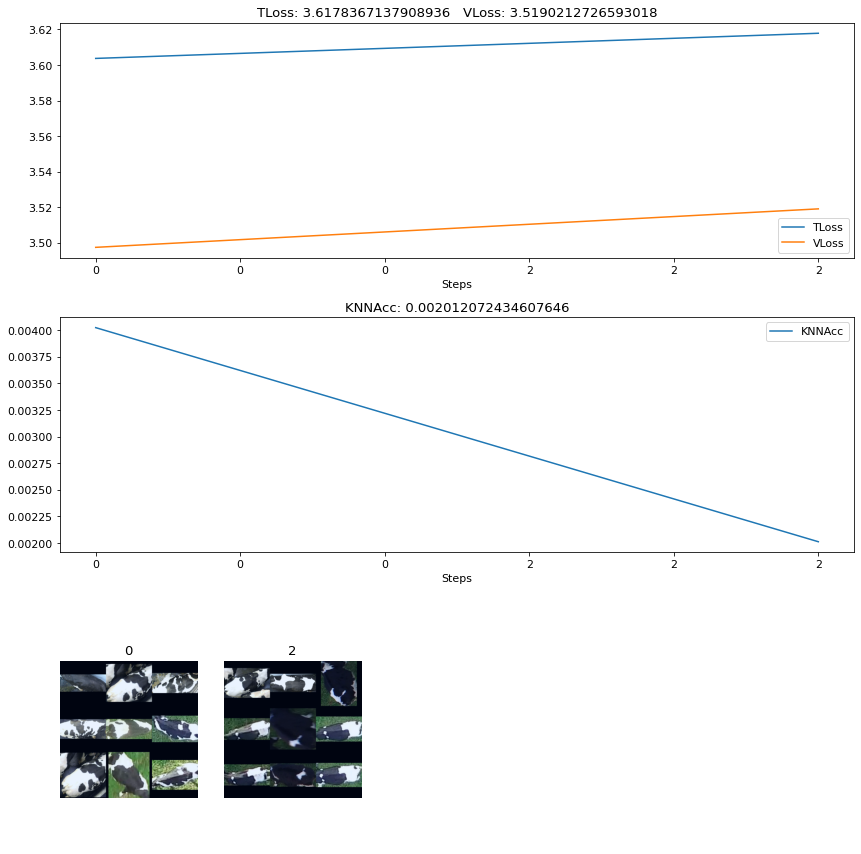

Training epochs:   1%|▏         | 4/300 [00:47<58:14, 11.81s/it]


KeyboardInterrupt: ignored

In [21]:
def evaluate(model, dataLoader, device, lossFn):
    model.eval()
    losses = []
    KNNTrainEMBDs, KNNTrainlabels = numpy.zeros((1, 128)), numpy.zeros((1))
    KNNTestEMBDs, KNNTestlabels = numpy.zeros((1, 128)), numpy.zeros((1))
    for step, (anchors, positives, negatives, anchorLabel, negativeLabel) in enumerate(dataLoader):
        anchors, positives, negatives, anchorLabel, negativeLabel = (
            anchors.to(device), positives.to(device), negatives.to(device),
            anchorLabel.view(len(anchorLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device)
        )
        # The forward method returns three embeddings
        negativeEMBD, anchorEMBD, positiveEMBD, prediction = model(
            negatives, anchors, positives
        )
        loss = lossFn(
            negativeEMBD, anchorEMBD,
            positiveEMBD, prediction,
            torch.cat((anchorLabel, anchorLabel, negativeLabel), dim=0),
        )
        losses.append(loss.data)

        KNNTrainEMBDs = numpy.concatenate((KNNTrainEMBDs, anchorEMBD.data.cpu().numpy()), axis=0)
        KNNTrainlabels = numpy.concatenate((KNNTrainlabels, anchorLabel.cpu().numpy()), axis=0)
        
        KNNTestEMBDs = numpy.concatenate((KNNTestEMBDs, positiveEMBD.data.cpu().numpy()), axis=0)
        KNNTestlabels = numpy.concatenate((KNNTestlabels, anchorLabel.cpu().numpy()), axis=0)

    return sum(losses) / len(losses), KNNTrainEMBDs, KNNTrainlabels, KNNTestEMBDs, KNNTestlabels

device, model, lossFn, testDL, trainDL, optimiser = experiment(
    "./datasets/OpenSetCows2020/splits/10-90.json",
    lossType="RTLSL",
    lRate=1e-5,
    decay=1e-4,
    momentum=0.9,
)

# Function to compose model input images in a grid
compose = lambda images, horizontal: numpy.concatenate(
    [img.permute(1, 2, 0) / 255 if horizontal == 1 else img for img in images],
    axis=horizontal,
)

# To store the data
history, canvas = hl.History(), hl.Canvas()
loss, numEpochs = 0, 300
model.train()

with tqdm(range(numEpochs), desc="Training epochs", position=0) as pbar:
    pbar.refresh()
    for epoch in range(numEpochs):  
        anchors, positives, negatives, anchorLabel, negativeLabel = next(
            iter(trainDL)
        )
        anchors, positives, negatives, anchorLabel, negativeLabel = (
            anchors.to(device), positives.to(device), negatives.to(device),
            anchorLabel.view(len(anchorLabel)).to(device),
            negativeLabel.view(len(negativeLabel)).to(device)
        )

        def closure():
          optimiser.zero_grad()
          # The forward method returns three embeddings
          negativeEMBD, anchorEMBD, positiveEMBD, prediction = model(
              negatives, anchors, positives
          )
          loss = tsl(
              negativeEMBD, anchorEMBD,
              positiveEMBD, prediction,
              torch.cat((anchorLabel, anchorLabel, negativeLabel), dim=0),
          )
          loss.backward()
          return loss

        loss = optimiser.step(closure)

        if epoch % 2 == 0:
            composite = compose(
                    [compose(negatives.cpu()[:3,], 1), compose(anchors.cpu()[:3,], 1), compose(positives.cpu()[:3,], 1)], 0
            )
            VLoss, trainEMBDs, trainLabels, testEMBDs, testLabels = evaluate(model, testingDataLoader, device, tsl)

            # Accuracy
            KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
            KNN.fit(trainEMBDs, trainLabels)
            predictions = KNN.predict(testEMBDs)
            correct = (predictions.astype(int) == testLabels.astype(int))
            accuracy = float((correct).sum()) / len(testLabels - 1)
            
            history.log(epoch, TLoss=loss.data, VLoss=VLoss, image=composite, KNNAcc=accuracy)
            model.train()
            with canvas:
                canvas.draw_plot([history["TLoss"], history["VLoss"]])
                canvas.draw_plot([history["KNNAcc"]])
                canvas.draw_image(history["image"])
        pbar.update()
    pbar.refresh()
# torch.save(model.state_dict(), "./trainedModel.pth")


In [ ]:
history.save("10-90.pkl")


# Model evaluation using KNN

<p align="center">
    <img src="https://github.com/Asheeshkrsharma/Identification-OpenCows/blob/main/staticAssets/KNNFit.png?raw=1" alt="Process" width="700"/>
</p>

In [22]:
from sklearn.neighbors import KNeighborsClassifier

def infer(model, imageLabel=None, dataLoader=None):
    """Infering the model for embeddings

    Parameters
    ----------
    model : Model to be used for training
        ResnetMod
    dataLoader : test/train dataloader object
        OpenSetCows2020

    Returns
    -------
    outputEMBDs
        Embeddings for a batch of images
    labelEMBDS
        Ground truth labels from the dataLoader for the embeddings
    """
    model.eval()
    # Embeddings/labels for training a KNN
    outputEMBDs, labelEMBDS = numpy.zeros((1, 128)), numpy.zeros((1))
    # We just need the images for the model to infer and the actual labels
    # to train fir KNN against
    if dataLoader != None:
        for images, _, _, labels, _ in tqdm(dataLoader):
            embeddings, _ = model(images.to(device))
            # Convert the data to numpy format
            embeddings, labels = (
                embeddings.data.cpu().numpy(),
                labels.view(len(labels)).cpu().numpy(),
            )
            # Store testing data on this batch ready to be evaluated
            outputEMBDs, labelEMBDS = numpy.concatenate(
                (outputEMBDs, embeddings), axis=0
            ), numpy.concatenate((labelEMBDS, labels), axis=0)
    else:
        images, labels = imageLabel
        embeddings, _ = model(images.to(device))
        embeddings, labels = (
                embeddings.data.cpu().numpy(),
                labels.view(len(labels)).cpu().numpy(),
        )
        outputEMBDs, labelEMBDS = numpy.concatenate(
                (outputEMBDs, embeddings), axis=0
        ), numpy.concatenate((labelEMBDS, labels), axis=0)
    return outputEMBDs, labelEMBDS


def calculateAccuracy(trainEMBD, trainLabels, testEMBD, testLabels):
    KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
    KNN.fit(trainEMBD, trainLabels)
    predictions = KNN.predict(testEMBD)
    correct = (predictions == testLabels)
    accuracy = float(numpy.count_nonzero(correct)) / (len(testLabels) - 1)
    return accuracy

# Weights trained on google collab
#model.load_state_dict(
#    torch.load("trainedModel98_RTL_SOFTMAX.pth", map_location=torch.device("cpu"))
#)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
testDataset = OpenSetCows2020(
    0,  # Fold 0
    foldsFile,
    split="test",
    transform=True,  # --------⎤
    combine=True,  # -----------> Arguments taken as specified in the Paper.
    suppress_info=True,  # ---⎦
)

testingDataLoader = DataLoader(testDataset, batch_size=5, num_workers=2, shuffle=False)
trainingDataLoader = DataLoader(trainDataset, batch_size=5, num_workers=2, shuffle=False)

print("Inferencing testing dataset")
testEMBD, testLEMBD = infer(model, dataLoader=testingDataLoader)
print("Inferencing training dataset")
trainEMBD, trainLEMBD = infer(model, dataLoader=trainingDataLoader)
print("\n KNN Accuracy on test dataset: {}".format(calculateAccuracy(trainEMBD, trainLEMBD, testEMBD, testLEMBD) * 100))

Inferencing testing dataset


100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


Inferencing training dataset


100%|██████████| 848/848 [01:16<00:00, 11.08it/s]



 KNN Accuracy on test dataset: 97.98387096774194


In [14]:
import seaborn as sns
from sklearn.manifold import TSNE

# perplexity mentioned in the paper is 30, rest arguments are mentioned as useful defaults
tSNE = TSNE(n_components=2, learning_rate='auto', perplexity=30, init='pca')

# t-SNE reduction for all embeddings (train and test) for a consistent latent space
reduction = tSNE.fit_transform(numpy.concatenate([trainEMBD, testEMBD], axis=0))
reductionTrain = reduction[:trainEMBD.shape[0], :]
reductionTest = reduction[trainEMBD.shape[0]:, :]

# Test the t-SNE latent space accuracy with KNN
print("KNN Accuracy after t-SNE reduction: {}".format(calculateAccuracy(reductionTrain, trainLEMBD, reductionTest, testLEMBD) * 100))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
c1Min, c1Max = reduction[:, 0].min() - 1, reduction[:, 0].max() + 1
c2Min, c2Max = reduction[:, 1].min() - 1, reduction[:, 1].max() + 1
xx, yy = numpy.meshgrid(
    numpy.linspace(c1Min, c1Max, 500), numpy.linspace(c2Min, c2Max, 500)
)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


KNN Accuracy after t-SNE reduction: 96.9758064516129


<p align="center">
    <img src="https://github.com/Asheeshkrsharma/Identification-OpenCows/blob/main/staticAssets/medialabSettings.png?raw=1" alt="Colors" width="700"/>
</p>
https://medialab.github.io/iwanthue/

Visiualization tweaks were adopted from [prettyplotlib: Painlessly create beautiful matplotlib plots](https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib/)

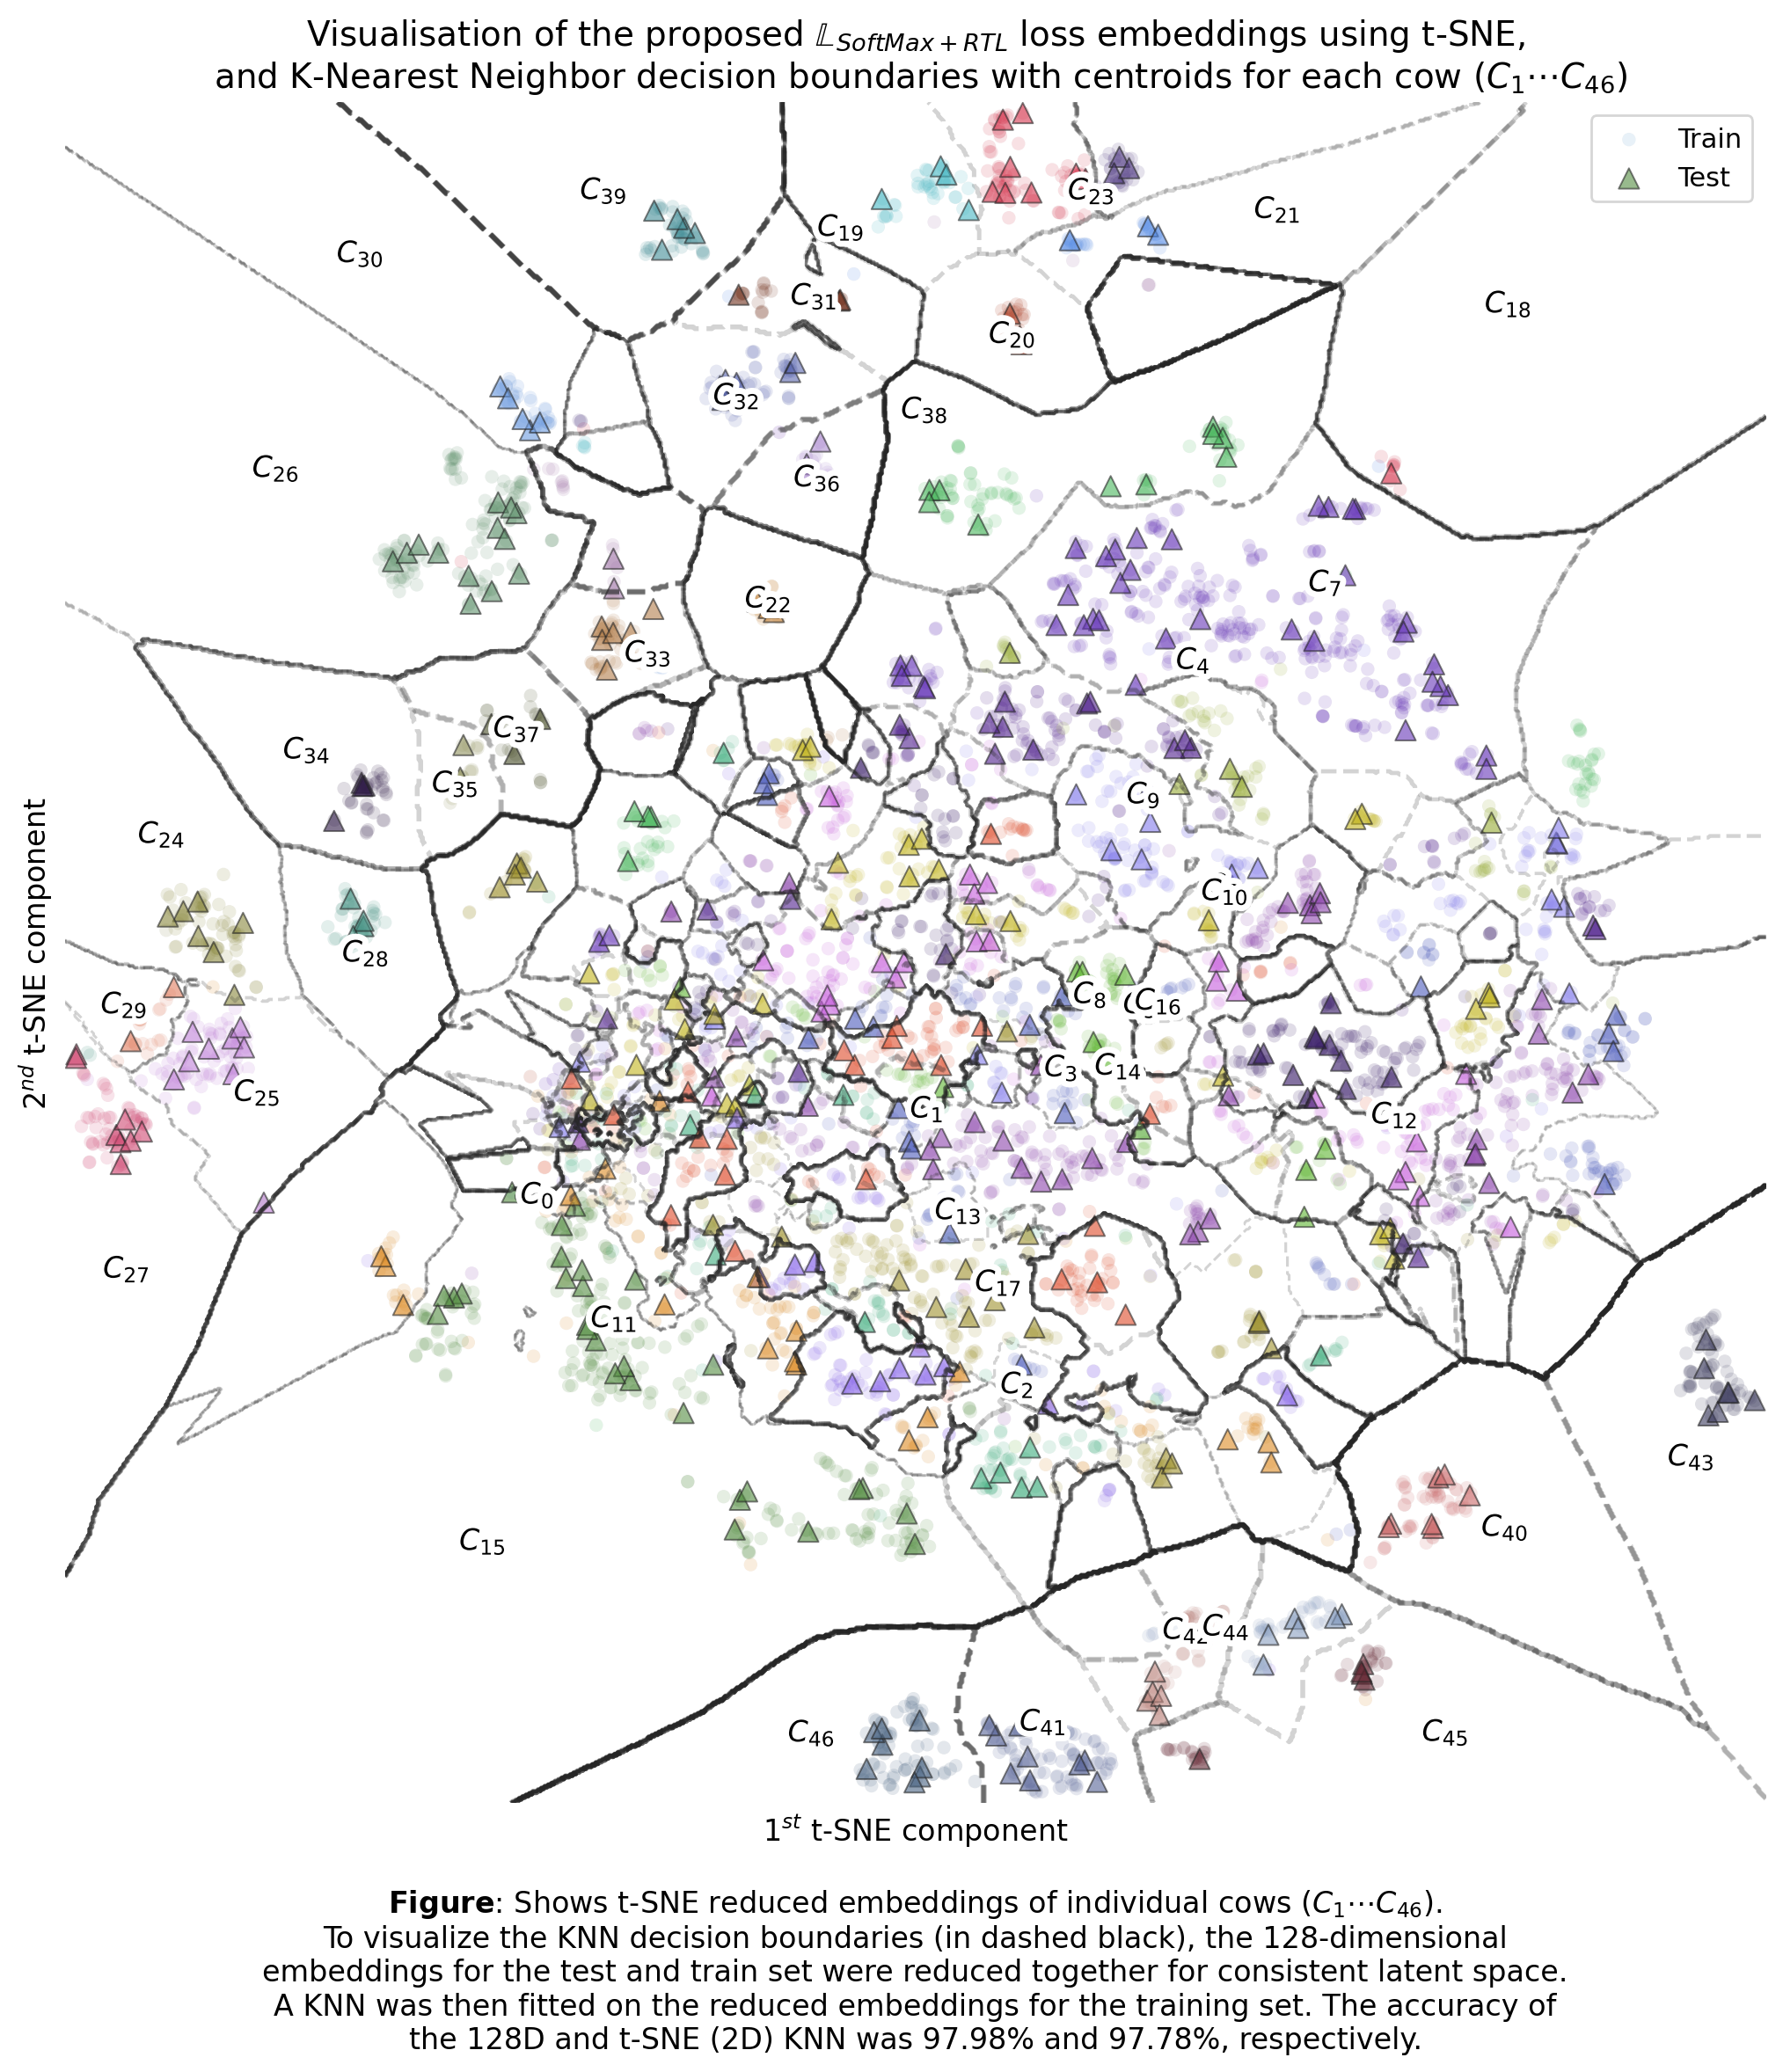

In [19]:
import matplotlib.patheffects as PathEffects

# Initialize plot
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)

# Custom colors from https://medialab.github.io/iwanthue/ as show in image above
colors = numpy.asarray(
    [
        [102, 162, 209], [222, 74, 41], [132, 96, 233], [94, 181, 49],
        [102, 54, 184], [194, 180, 29], [78, 31, 140], [72, 182, 92],
        [198, 92, 220], [151, 171, 52], [130, 123, 235], [221, 139, 36],
        [76, 91, 188], [159, 146, 46], [140, 68, 172], [83, 141, 65],
        [50, 21, 99], [61, 173, 125], [214, 54, 79], [70, 183, 195],
        [175, 66, 40], [83, 138, 229], [195, 128, 52], [84, 62, 134],
        [137, 135, 60], [191, 127, 216], [97, 147, 110], [208, 72, 114],
        [73, 148, 134], [224, 124, 94], [107, 154, 223], [114, 50, 30],
        [92, 104, 176], [179, 126, 75], [48, 28, 72], [144, 146, 93],
        [173, 140, 208], [71, 76, 39], [162, 120, 170], [65, 141, 150],
        [203, 105, 106], [86, 98, 151], [188, 133, 126], [59, 58, 93],
        [137, 159, 193], [101, 40, 52], [72, 99, 130],
    ]
)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
c1Min, c1Max = reduction[:, 0].min() - 1, reduction[:, 0].max() + 1
c2Min, c2Max = reduction[:, 1].min() - 1, reduction[:, 1].max() + 1
xx, yy = numpy.meshgrid(
    numpy.linspace(c1Min, c1Max, 1000), numpy.linspace(c2Min, c2Max, 1000)
)

# Fit K-NN classifier on the reduced TSNE embedding, only training
# part of the dataset is used
KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
KNN.fit(reductionTrain, trainLEMBD)
# Predict over the mesh grid for visualization
Z = KNN.predict(numpy.c_[xx.ravel(), yy.ravel()])

def centeroid(data):
    x, y = zip(*data)
    return sum(x) / len(x), sum(y) / len(x)

# Calculate centroids for the KNN predictions for each cow
ft = numpy.c_[xx.ravel(), yy.ravel()]
for cat in numpy.unique(Z.astype(dtype=numpy.int32)):
    x, y = centeroid(ft[numpy.where(Z == cat)[0]])
    text = ax.text( x, y, f"$C_{{{cat}}}$",
        fontsize=12,
        horizontalalignment="center",
        verticalalignment="center",
    )
    # Text white outline: https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# Line width gets progressively smaller down the levels
lineWidths = numpy.linspace(2, 1, int((trainDataset.getNumClasses() + 1) / 3))
lineWidths = numpy.concatenate([lineWidths, numpy.linspace(2, 1, int((trainDataset.getNumClasses() + 1) / 3))])
lineWidths = numpy.concatenate([lineWidths, numpy.ones(int((trainDataset.getNumClasses() + 1) / 3)) * 2])

# Draw the contours for the KNN decision boundaries
CS = ax.contour(
    xx, yy, Z.reshape(xx.shape).astype(dtype=numpy.int32),
    trainDataset.getNumClasses() + 1,
    alpha=0.2, colors="#262626",
    antialiased=True, linewidths=lineWidths,
    linestyles="dashed",
    corner_mask=False
)

# this might be necessary on interactive sessions: redraw figure
plt.gcf().canvas.draw()

# Scatter plot for train set symbol: ○
faceColors = [colors[int(label)] / 255. for label in trainLEMBD]
ax.scatter(
    reductionTrain[:, 0], reductionTrain[:, 1],
    s=30, alpha=0.15, edgecolor="#262626",
    facecolor=faceColors, linewidth=0.02,
    label='Train'
)

# Scatter plot for test set symbol: △
faceColors = [colors[int(label)] / 255. for label in KNN.predict(reductionTest)]
ax.scatter(
    reductionTest[:, 0], reductionTest[:, 1],
    s=70, alpha=0.6, edgecolor="#262626",
    facecolor=faceColors, linewidth=0.7,
    marker="^",
    label='Test'
)

# Viz tweaks https://olgabotvinnik.com/blog/prettyplotlib-painlessly-create-beautiful-matplotlib
[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()

# Titles and labels
plt.tight_layout()
plt.ylabel('$2^{nd}$ t-SNE component', fontsize=12)
plt.xlabel('''$1^{st}$ t-SNE component

$\\bf{Figure}$: Shows t-SNE reduced embeddings of individual cows ($C_1\cdots C_{46}$).
To visualize the KNN decision boundaries (in dashed black), the 128-dimensional
embeddings for the test and train set were reduced together for consistent latent space.
A KNN was then fitted on the reduced embeddings for the training set. The accuracy of
the 128D and t-SNE (2D) KNN was 97.98% and 97.78%, respectively.''', fontsize=12)
plt.title('Visualisation of the proposed $\mathbb{L}_{SoftMax + RTL}$ loss embeddings using t-SNE,\n and K-Nearest Neighbor decision boundaries with centroids for each cow ($C_{1}\cdots C_{46}$)', fontsize=14)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [ ]:
torch.save(model.state_dict(), "./trainedModel98_RTL_SOFTMAX.pth")

In [ ]:
import umap
fit = umap.UMAP(n_neighbors=5)
%time reduction = fit.fit_transform(trainEMBD, y=trainLEMBD)

CPU times: user 28 s, sys: 12.1 s, total: 40 s
Wall time: 7.12 s


Text(0.5, 238.88888888888889, '$1^{st}$ UMAP component')

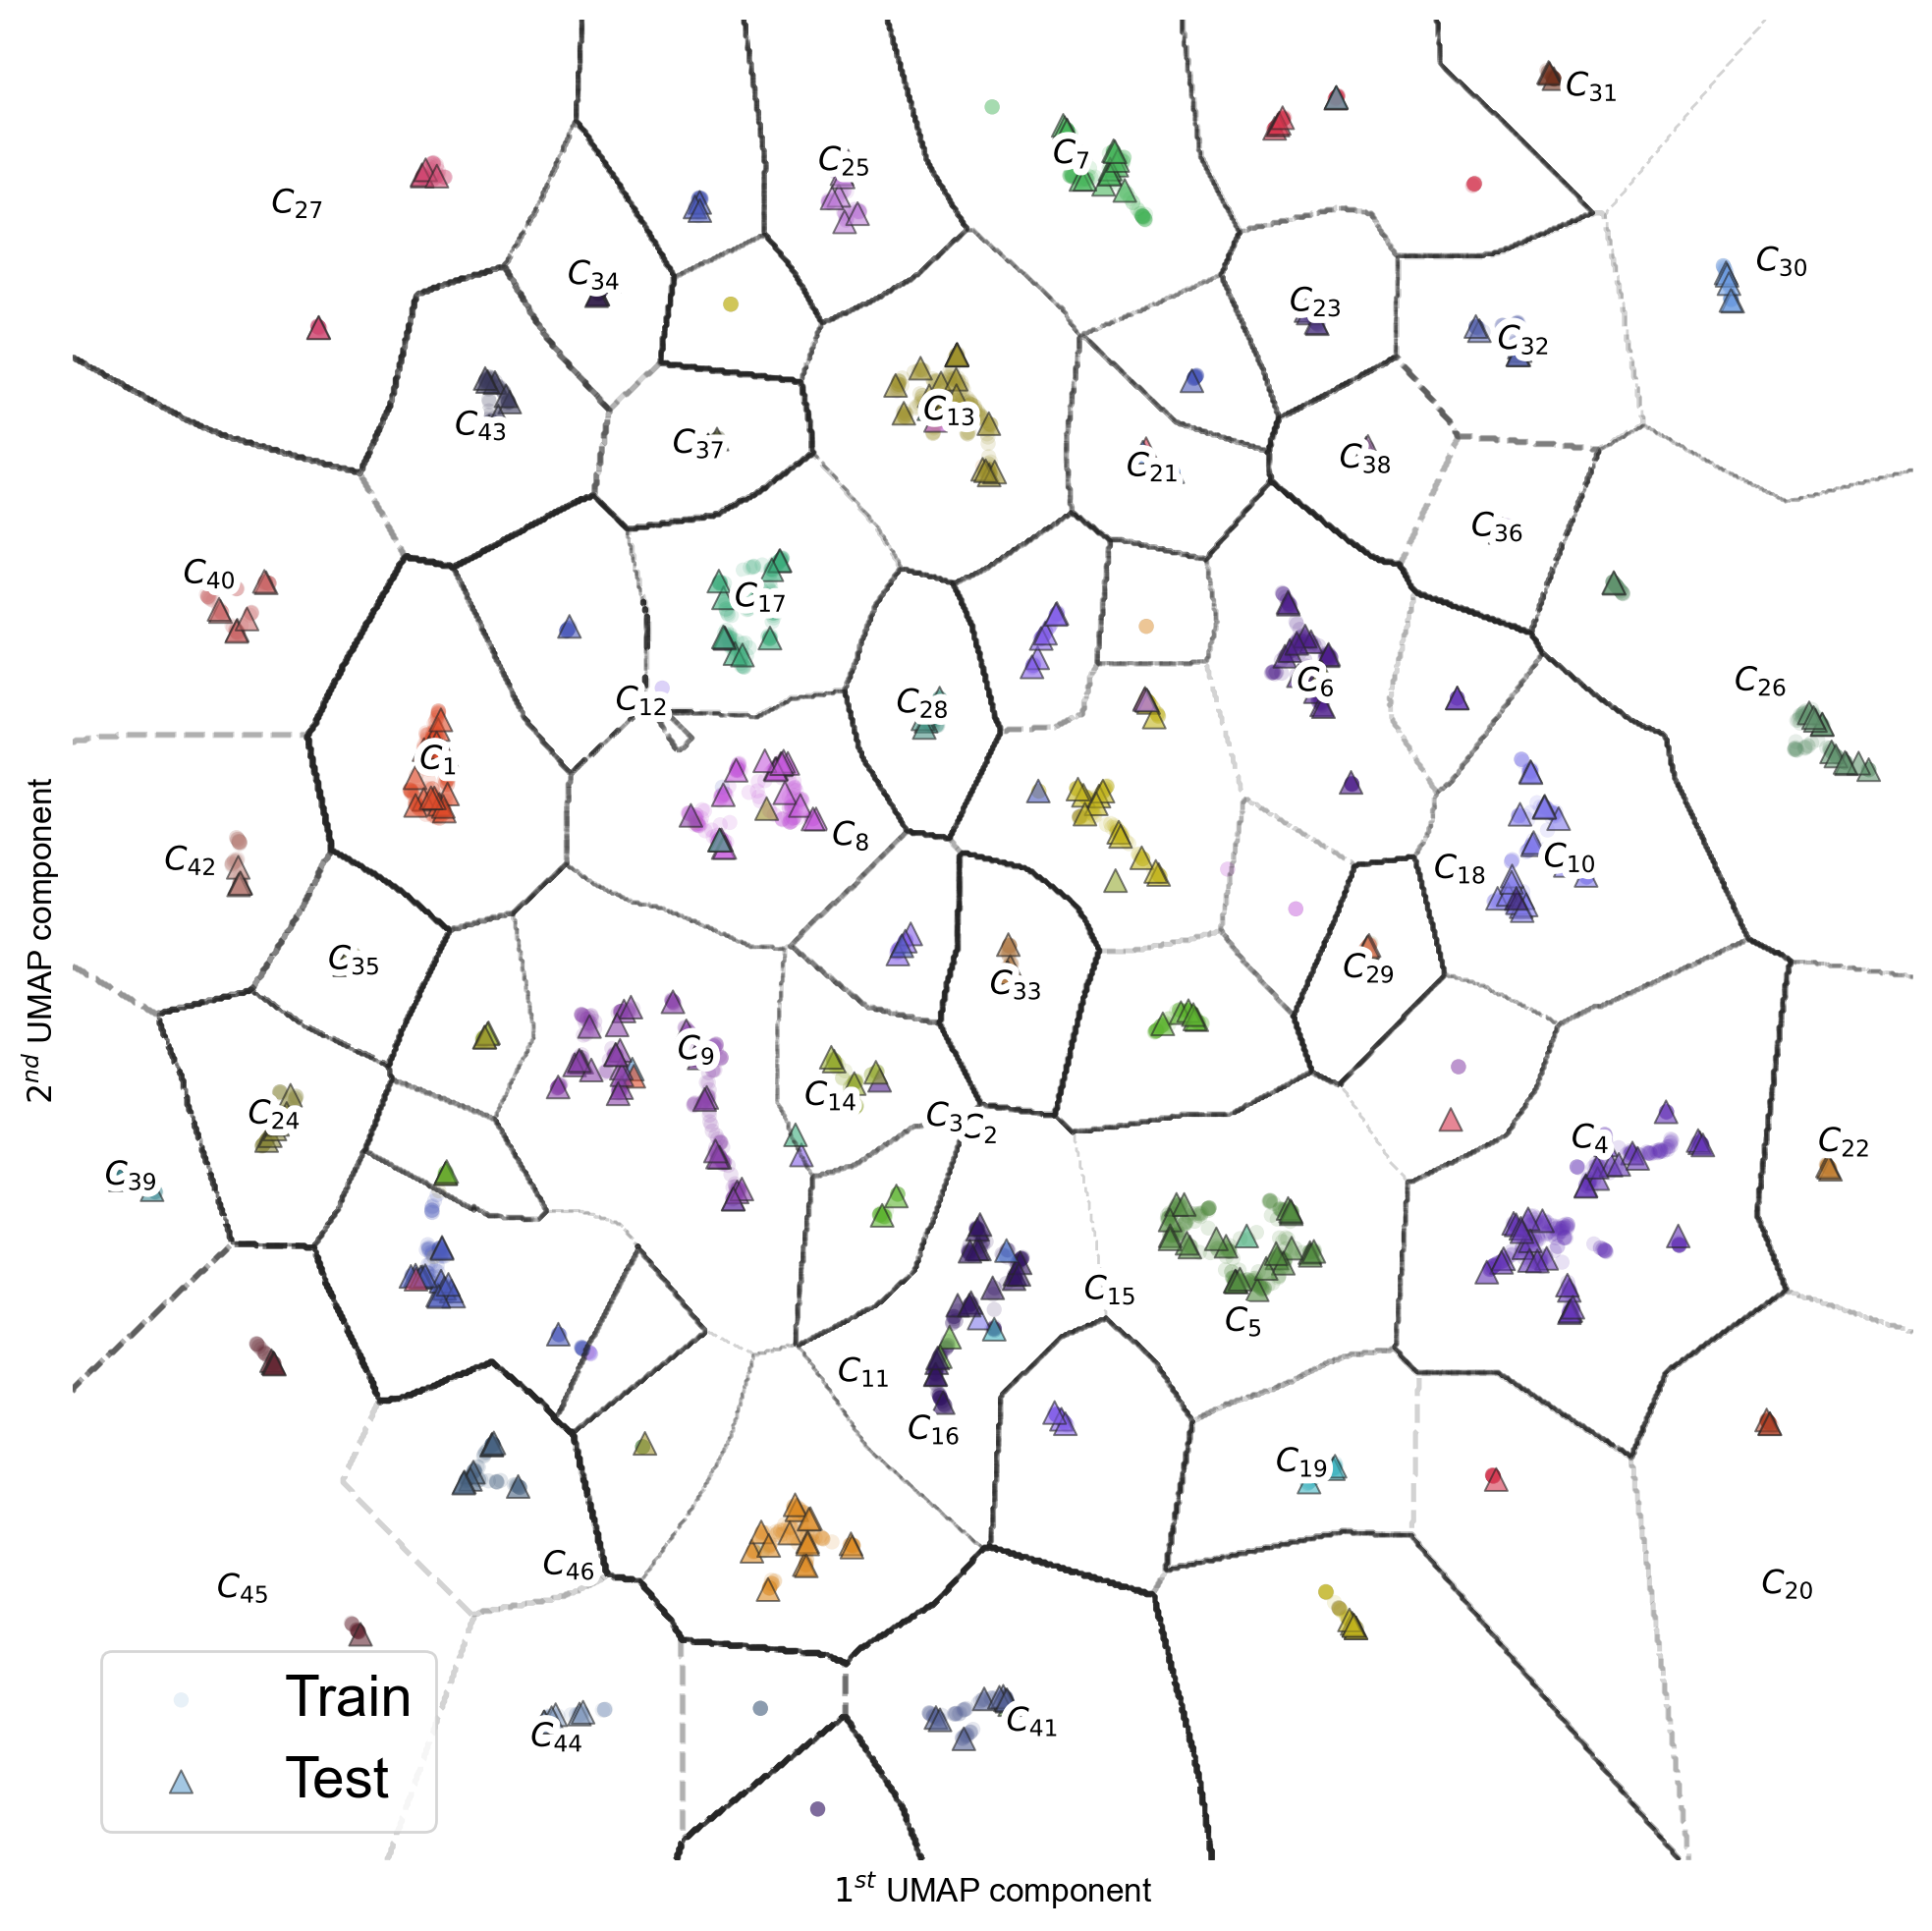

In [ ]:
# Initialize plot
plt.rcParams["figure.figsize"] = (10, 10)
fig, ax = plt.subplots(1, dpi=200)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
c1Min, c1Max = reduction[:, 0].min() - 1, reduction[:, 0].max() + 1
c2Min, c2Max = reduction[:, 1].min() - 1, reduction[:, 1].max() + 1
xx, yy = numpy.meshgrid(
    numpy.linspace(c1Min, c1Max, 1000), numpy.linspace(c2Min, c2Max, 1000)
)

# Fit K-NN classifier on the reduced TSNE embedding, only training
# part of the dataset is used
KNN = KNeighborsClassifier(n_neighbors=5, n_jobs=-4)
KNN.fit(reduction, trainLEMBD)
# Predict over the mesh grid for visualization
Z = KNN.predict(numpy.c_[xx.ravel(), yy.ravel()])

def centeroid(data):
    x, y = zip(*data)
    return sum(x) / len(x), sum(y) / len(x)

# Calculate centroids for the KNN predictions for each cow
ft = numpy.c_[xx.ravel(), yy.ravel()]
for cat in numpy.unique(Z.astype(dtype=numpy.int32)):
    x, y = centeroid(ft[numpy.where(Z == cat)[0]])
    text = ax.text( x, y, f"$C_{{{cat}}}$",
        fontsize=12,
        horizontalalignment="center",
        verticalalignment="center",
    )
    # Text white outline: https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

# Line width gets progressively smaller down the levels
lineWidths = numpy.linspace(2, 1, int((trainDataset.getNumClasses() + 1) / 3))
lineWidths = numpy.concatenate([lineWidths, numpy.linspace(2, 1, int((trainDataset.getNumClasses() + 1) / 3))])
lineWidths = numpy.concatenate([lineWidths, numpy.ones(int((trainDataset.getNumClasses() + 1) / 3)) * 2])

# Draw the contours for the KNN decision boundaries
CS = ax.contour(
    xx, yy, Z.reshape(xx.shape).astype(dtype=numpy.int32),
    trainDataset.getNumClasses() + 1,
    alpha=0.2, colors="#262626",
    antialiased=True, linewidths=lineWidths,
    linestyles="dashed",
    corner_mask=False
)

faceColors = [colors[int(label)] / 255. for label in trainLEMBD]
ax.scatter(
    reduction[:,0], reduction[:,1], s=30, alpha=0.15, edgecolor="#262626",
    facecolor=faceColors,
    linewidth=0.02,
    label='Train'
)

testEmbeding = fit.transform(testEMBD)
# Scatter plot for test set symbol: △
faceColors = [colors[int(label)] / 255. for label in testLEMBD]
ax.scatter(
    testEmbeding[:, 0], testEmbeding[:, 1],
    s=70, alpha=0.6, edgecolor="#262626",
    facecolor=faceColors, linewidth=0.7,
    marker="^",
    label='Test'
)

[ax.spines[spine].set_visible(False) for spine in ["top", "right", "bottom", "left"]]
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
ax.axis("tight")
ax.legend()

# Titles and labels
plt.tight_layout()
plt.ylabel('$2^{nd}$ UMAP component', fontsize=12)
plt.xlabel('''$1^{st}$ UMAP component''', fontsize=12)

# References
<span id="fn1">[1]</span>: Andrew, W., Gao, J., Mullan, S., Campbell, N., Dowsey, A. W., & Burghardt, T. (2021). Visual identification of individual Holstein-Friesian cattle via deep metric learning. Computers and Electronics in Agriculture, 185, 106133.

<span id="fn2">[2]</span>: William Andrew, Tilo Burghardt, Neill Campbell, Jing Gao (2020): OpenCows2020. https://doi.org/10.5523/bris.10m32xl88x2b61zlkkgz3fml17

<span id="fn3">[3]</span>: He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).